In [1]:
import os, time, random, math, shutil, random
import csv
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Audio

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio.functional as F
import torchaudio.transforms as T

import librosa

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPU to use

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 138

# data

## dataload
- label이 있는 데이터를 불러오고, 그것들을 target으로 옮기기

In [5]:
label = pd.read_csv('data/label_list.csv')

In [37]:
import shutil
for i in range(len(names)):
    filename = str('data/origin_wav/' + names['filename'][i] + '.wav')
    copyname = str('data/seg_wav/' + names['filename'][i] + '.wav')
    shutil.copy(filename, copyname)

In [39]:
for i in range(len(names)):
    filename = str('data/wav/' + names['filename'][i] + '.wav')
    wav, sr = torchaudio.load(filename)
    print(sr)

48000
48000
48000
48000
48000
48000
48000
48000
44100
44100
44100
44100
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000


## data summary

### 데이터 길이 확인

In [8]:
length = []
filename = str('hello')
for i in range(len(data)):
    if filename == data.filename[i]:
        pass
    else:
        filename = data.filename[i]
        waveform, sample_rate = torchaudio.load(os.path.join(param.data_path,filename)+'.wav')
        resize = torchaudio.transforms.Resample(sample_rate, param.sample_rate)(waveform)
        length.append(len(resize[0])/22050)

In [9]:
np.max(length)

27.360680272108844

In [10]:
data.end.max()

23.866

data의 최대 길이는 27.36초이나 wheezing이 존재하는 최대의 길이는 23.86이므로 25초까지만 패딩하자.

### 스테레오 여부 확인

In [11]:
for i in range(len(data)):
    if filename == data.filename[i]:
        pass
    else:
        filename = data.filename[i]
        waveform, sample_rate = torchaudio.load(os.path.join(param.data_path,filename)+'.wav')
        print(f'{filename}s channel : {waveform.shape[0]}')

0001-1s channel : 1
0001-3s channel : 1
0001-4s channel : 1
0020-1s channel : 1
0020-3s channel : 1
0020-4s channel : 1
0025-3s channel : 1
0025-4s channel : 1
0107-1s channel : 1
0107-2s channel : 1
0107-3s channel : 1
0107-4s channel : 1
0261-2s channel : 1
0261-3s channel : 1
0411-2s channel : 1
0411-3s channel : 1
0515-1s channel : 1
0526-3s channel : 1
0526-4s channel : 1
0533-1s channel : 1
0533-2s channel : 1
0534-4s channel : 1
0535-3s channel : 1
0538-1s channel : 1
0538-2s channel : 1
0538-3s channel : 1
0538-4s channel : 1
0539-3s channel : 1
0539-4s channel : 1
0549-2s channel : 1
0550-3s channel : 1
0550-4s channel : 1
0559-1s channel : 1
0559-2s channel : 1
0559-3s channel : 1
0559-4s channel : 1
0568-1s channel : 1
0568-2s channel : 1
0568-3s channel : 1
0568-4s channel : 1
0581-1s channel : 1
0581-2s channel : 1
0581-4s channel : 1
0588-2s channel : 1
0588-3s channel : 1
0590-1s channel : 1
0590-2s channel : 1
0590-3s channel : 1
0593-3s channel : 1
0593-4s channel : 1


In [12]:
from sklearn.model_selection import train_test_split, KFold

In [13]:
train_set, test_set = train_test_split(data,test_size=0.2, random_state=param.random_state)

In [14]:
print(f'train : {len(train_set)}, test : {len(test_set)}')

train : 151, test : 38


## audio preprocess

## 1채널로 만들기

In [1]:
from subprocess import Popen, PIPE

In [6]:
audio_files = glob.glob('data/labeled_wheezing/*.wav')

In [8]:
audio_files = glob.glob('data/non_wheezing/*.wav')

In [9]:
for sound in audio_files:
    temp_file = sound.replace("non_wheezing","mono_non_wheezing")
    command = "sox " + sound + " " + temp_file + " channels 1"
    p = Popen(command, stdin=PIPE, stdout=PIPE, stderr=PIPE, shell=True)
    output, err = p.communicate()

### non-wheezing label 만들기

In [30]:
non_wheezings = glob.glob('data/mono_non_wheezing/*.wav')

In [31]:
for _, path in enumerate(non_wheezings):
    with open(path.replace('.wav','.ann'), 'w') as fp:
        fp.write('0,0,non-wheezing')
    fp.close()

## label 분할

In [12]:
label = pd.read_csv('data/label_list.csv')
data = np.array(label)

In [27]:
def label_seperate(audio_path, data):
    now = data[0][0]
    lists = []
    count = 0
    for i in range(len(data)):
        if now == data[i][0]:
            lists.append(data[i])
        elif count != 0 : 
            label_name=f'{audio_path}/{data[i-1][0]}.ann'
            with open(label_name, 'w') as fp:
                fp.write('\n'.join('{},{},{}'.format(x[2], x[3], x[1]) for x in lists))
            lists = []
            now=data[i][0]
            lists.append(data[i])
        else :
            now=data[i][0]
            lists.append(data[i])
        count += 1
    label_name=f'{audio_path}/{data[i][0]}.ann'
    with open(label_name, 'w') as fp:
        fp.write('\n'.join('{},{},{}'.format(x[2], x[3], x[1]) for x in lists))

In [29]:
label_seperate('data/mono_wheezing',data=data)

## 레이블 관련 함수(실행해야함)

In [3]:
def construct_labels(annotation_path, win_start, win_end, win_len):
    events = read_annotation(annotation_path)
    #원래 3번째 값은 e[2]로 특정 클래스인데, 여긴 binary니깐 1로 변경
    ann = [[float(e[0]), float(e[1]), 1] for e in events]
    
    curr_ann = []
    
    for a in ann:
        if a[1] > win_start and a[0] <= win_end: 
        # if a[0] >= win_start and a[0] < win_end:
            curr_start = max(a[0] - win_start, 0.0)
            curr_end = min(a[1] - win_start, win_len)
            curr_ann.append([curr_start, curr_end, a[2]])    
    
    class_set = set([c[2] for c in curr_ann])
    class_wise_events = {}
    
    for c in list(class_set):
        class_wise_events[c] = []
        
    
    for c in curr_ann:
        class_wise_events[c[2]].append(c)
        
    max_event_silence = 0.0
    all_events = []
    
    for k in list(class_wise_events.keys()):
        curr_events = class_wise_events[k]
        count = 0
    
        while count < len(curr_events) - 1:
            if (curr_events[count][1] >= curr_events[count + 1][0]) or (curr_events[count + 1][0] - curr_events[count][1] <= max_event_silence):
                curr_events[count][1] = max(curr_events[count + 1][1], curr_events[count][1])
                del curr_events[count + 1]
            else:
                count += 1
        
        all_events += curr_events
    
    for i in range(len(all_events)):
        all_events[i][0] = round(all_events[i][0], 3)/0.3
        all_events[i][1] = round(all_events[i][1], 3)/0.3
    
    all_events.sort(key=lambda x: x[0])
    if all_events==[]:
        all_events=[[0, 0, 0]]
  
    return all_events

In [4]:
def read_annotation(filename):
    events = []
    with open(filename, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            events.append(row)
    return events

## 멜스펙트로그램 그려보기

In [68]:
wav, sr = torchaudio.load('data/mono_wav/0261-2.wav')

In [69]:
wav = T.Resample(sr, 44100)(wav)[0]

In [210]:
seg_wav = wav[int(44100*0.3)*2:int(44100*0.3)*3]

In [187]:
seg_wav = wav[int(44100)*0:int(44100)*3]

In [71]:
len(seg_wav)

13230

In [25]:
import librosa

In [141]:
librosa.feature.melspectrogram

<function librosa.feature.spectral.melspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512, win_length=None, window='hann', center=True, pad_mode='reflect', power=2.0, **kwargs)>

In [143]:
seg_wav

tensor([0.0069, 0.0074, 0.0073,  ..., 0.0122, 0.0124, 0.0126])

In [118]:
librosa.feature.melspectrogram?

Signature:
librosa.feature.melspectrogram(
    y=None,
    sr=22050,
    S=None,
    n_fft=2048,
    hop_length=512,
    win_length=None,
    window='hann',
    center=True,
    pad_mode='reflect',
    power=2.0,
    **kwargs,
)
Docstring:
Compute a mel-scaled spectrogram.

If a spectrogram input ``S`` is provided, then it is mapped directly onto
the mel basis by ``mel_f.dot(S)``.

If a time-series input ``y, sr`` is provided, then its magnitude spectrogram
``S`` is first computed, and then mapped onto the mel scale by
``mel_f.dot(S**power)``.

By default, ``power=2`` operates on a power spectrum.

Parameters
----------
y : np.ndarray [shape=(n,)] or None
    audio time-series

sr : number > 0 [scalar]
    sampling rate of ``y``

S : np.ndarray [shape=(d, t)]
    spectrogram

n_fft : int > 0 [scalar]
    length of the FFT window

hop_length : int > 0 [scalar]
    number of samples between successive frames.
    See `librosa.stft`

win_length : int <= n_fft [scalar]
    Each frame of au

In [119]:
T.MelSpectrogram?

Init signature:
T.MelSpectrogram(
    sample_rate: int = 16000,
    n_fft: int = 400,
    win_length: Union[int, NoneType] = None,
    hop_length: Union[int, NoneType] = None,
    f_min: float = 0.0,
    f_max: Union[float, NoneType] = None,
    pad: int = 0,
    n_mels: int = 128,
    window_fn: Callable[..., torch.Tensor] = <built-in method hann_window of type object at 0x7f7e55fd1ce0>,
    power: Union[float, NoneType] = 2.0,
    normalized: bool = False,
    wkwargs: Union[dict, NoneType] = None,
    center: bool = True,
    pad_mode: str = 'reflect',
    onesided: bool = True,
    norm: Union[str, NoneType] = None,
) -> None
Docstring:     
Create MelSpectrogram for a raw audio signal. This is a composition of Spectrogram
and MelScale.

Sources
    * https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
    * https://timsainb.github.io/spectrograms-mfccs-and-inversion-in-python.html
    * http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

Args:
    

In [ ]:
sr = 44100, hop_length = 441, win_length = 1764, n_fft = 2048, n_mels = 40, fmin = 0, fmax = 22050

(60, 414)


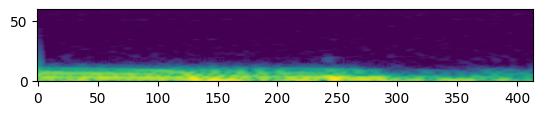

In [233]:
bands = librosa.feature.melspectrogram(y=np.array(seg_wav), sr=44100, hop_length=32, win_length = 511, n_fft=1024, n_mels=60, dtype=np.float32)
bands = librosa.core.power_to_db(bands)
print(bands.shape)
plt.imshow(bands, origin='lower')

torch.Size([60, 31])


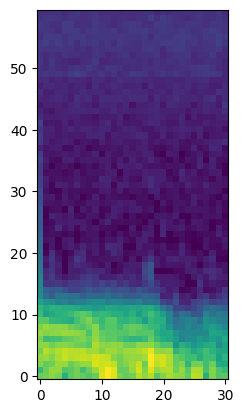

In [221]:
mel = T.MelSpectrogram(sample_rate=44100, hop_length=441, win_length=882, n_fft = 2048, n_mels = 60)(seg_wav)
mel = T.AmplitudeToDB(top_db=80)(mel)
print(mel.shape)
plt.imshow(mel, origin='lower')

## 오디오 분할

In [5]:
params={
    "wav_len" : 0.3,
    "wav_hop" : 0.2,
    "sr" : 44100,
    "n_fft" : 2048,
    "mel_win" : 882,
    "mel_hop" : 441, #torchaudio default로써 hop_length=nfft//2
    "n_mels" : 40,
    "top_db" : 80 #torchaudio가 80이 합리적이라고 함. 근데 보니깐 이게 호흡음이고, 작은 소리였다보니 80은 불필요한 수준일수도
}

In [5]:
wheezing_wavs = glob.glob('data/mono_wheezing/*.wav')

In [34]:
save_folder = 'data/sep_wav/w2h1m4'
try : 
    #os.mkdir(f'data/sep_wav')
    os.mkdir(f'{save_folder}')
    os.mkdir(f'{save_folder}/non_wheezing')
    os.mkdir(f'{save_folder}/wheezing')
except:
    print('already exist')

already exist


In [26]:
#spectrogram과 레이블을 0.3초 단위로 다 자르기
for num, data in enumerate(wheezing_wavs):
    wav, sr = librosa.load(data)
    wav = librosa.resample(wav, orig_sr=sr, target_sr=params['sr'])
    mels = []
    labels = []
    
    interval_nums = int(np.ceil(len(wav)/params['sr']/params['wav_hop']))
    for i in range(interval_nums):
        # make part of wav
        start_time = i*int(params['sr']*params['wav_hop'])
        end_time = i*int(params['sr']*params['wav_hop'])+int(params['sr']*params['wav_len'])    
        new_wav = wav[start_time:end_time]

        # zero-padding
        if new_wav.shape[0] < params['sr']*params['wav_len']:
            zeros = np.zeros(int(params['sr']*params['wav_len']) - len(new_wav))
            new_wav = np.concatenate([new_wav, zeros])

        # make melspectrogram
        if sum(np.abs(new_wav))==0:
            print('pass') # there is no information don't need this wav
        else : 
            mel = librosa.feature.melspectrogram(y=np.array(new_wav), sr=params['sr'], hop_length=params['mel_hop'], win_length = params['mel_win'], n_fft=params['n_fft'], n_mels=params['n_mels'], dtype=np.float32)
            mel = librosa.core.power_to_db(mel)
        
            label = construct_labels(data.replace('.wav','.ann'), win_start = i*params['wav_hop'], win_end = i*params['wav_hop'] + params['wav_len'], win_len = params['wav_len'])

            #classification of wheezing
            if sum(label[0])==0:
                interval_name = data[:-4].replace('data/mono_wheezing',f'{save_folder}/non_wheezing')+f'_{i}'
            else:
                interval_name = data[:-4].replace('data/mono_wheezing',f'{save_folder}/wheezing')+f'_{i}'

            #save
            np.save(f'{interval_name}.npy', mel)
            with open(f'{interval_name}.ann', 'w') as fp:
                fp.write('\n'.join('{},{},{}'.format(x[0], x[1], x[2]) for x in label))

pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass


In [27]:
non_wheezing_wavs = glob.glob('data/mono_non_wheezing/*.wav')

In [28]:
#spectrogram과 레이블을 0.3초 단위로 다 자르기
for num, data in enumerate(non_wheezing_wavs):
    wav, sr = librosa.load(data)
    wav = librosa.resample(wav, orig_sr=sr, target_sr=params['sr'])
    mels = []
    labels = []
    
    interval_nums = int(np.ceil(len(wav)/params['sr']/params['wav_hop']))
    for i in range(interval_nums):
        # make part of wav
        interval_name = data[:-4].replace('data/mono_non_wheezing',f'{save_folder}/non_wheezing')+f'_{i}'
        start_time = i*int(params['sr']*params['wav_hop'])
        end_time = i*int(params['sr']*params['wav_hop'])+int(params['sr']*params['wav_len'])    
        new_wav = wav[start_time:end_time]

        # zero-padding
        if new_wav.shape[0] < params['sr']*params['wav_len']:
            zeros = np.zeros(int(params['sr']*params['wav_len']) - len(new_wav))
            new_wav = np.concatenate([new_wav, zeros])

        # make mel
        if sum(np.abs(new_wav))==0:
            print('pass') # there is no information don't need this wav
        else : 
            mel = librosa.feature.melspectrogram(y=np.array(new_wav), sr=params['sr'], hop_length=params['mel_hop'], win_length = params['mel_win'], n_fft=params['n_fft'], n_mels=params['n_mels'], dtype=np.float32)
            mel = librosa.core.power_to_db(mel)
            np.save(f'{interval_name}.npy', mel)

            # save
            label = construct_labels(data.replace('.wav','.ann'), win_start = i*params['wav_hop'], win_end = i*params['wav_hop']+params['wav_len'], win_len = params['wav_len'])
            with open(f'{interval_name}.ann', 'w') as fp:
                fp.write('\n'.join('{},{},{}'.format(x[0], x[1], x[2]) for x in label))

## dataset

In [8]:
# sample rate 22050, n_mels=64, n_fft=int(0.2625*args.length)
# sr 16000, hop_length=160, win_length=400, n_fft=512, n_mels=64, f_min=125, f_max=7500

In [5]:
wheezings = glob.glob('data/sep_wav/w2h1m4/wheezing/*.npy')
non_wheezings = glob.glob('data/sep_wav/w2h1m4/non_wheezing/*.npy')
random.seed(seed)
random.shuffle(wheezings)
random.shuffle(non_wheezings)

In [6]:
class Breath_Dataset(torch.utils.data.Dataset):
    def __init__(self, wheezing, non_wheezing, ratio=1):
        self.wheezings = wheezing
        self.non_wheezings = non_wheezing
        self.ratio = ratio
        self.data = wheezing+non_wheezing
        random.shuffle(self.data)
        
    def __len__(self):
        return len(self.data)

    # 매 에포크마다 downsampling되도록 + test 성능 고정되게 나오게 하기 위하여
    def downsampling(self, seed=None):
        if seed != None:
            random.seed(seed)
        random.shuffle(self.non_wheezings)
        self.data = self.wheezings+self.non_wheezings[:len(self.wheezings)*self.ratio]
        random.shuffle(self.data)
        
    def __getitem__(self, index):
        # process : load -> resampling -> padding -> mel_spectro_gram -> spec_augment
        mel = np.load(self.data[index])
        ann = np.array(read_annotation(self.data[index].replace('.npy','.ann')), dtype=float)
        
        return mel, ann[0]

In [7]:
wheez_train, wheez_val = train_test_split(wheezings, test_size=int(len(wheezings)*0.2), random_state=seed)
non_wheez_train, non_wheez_val = train_test_split(non_wheezings, test_size=int(len(wheezings)*0.2), random_state=seed)

In [8]:
train_dataset = Breath_Dataset(wheez_train, non_wheez_train, ratio=1)
train_dataset.downsampling()
val_dataset = Breath_Dataset(wheez_val, non_wheez_val, ratio=1)

In [9]:
train_loader = DataLoader(train_dataset, batch_size = 32, num_workers = 0, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, num_workers = 0, shuffle = False)

In [10]:
print(f'total : {len(train_dataset)+len(val_dataset)} \n\n\
train : {len(train_dataset)} \n\
train_wheezing : {len(train_dataset.wheezings)} \n\n\
val : {len(val_dataset)} \n\
val_wheezing : {len(val_dataset.wheezings)}')

total : 1294 

train : 1036 
train_wheezing : 518 

val : 258 
val_wheezing : 129


## datasplit

# loss function and optimizer
- label의 0은 시작지점, 1은 끝지점, 2가 클래스

In [11]:
MSE = nn.MSELoss()

In [12]:
BCE = nn.BCELoss()

In [13]:
#label이 0인것은 시간loss가 없어야한다.
#그런데 loss 계산 전에 0으로 만들었더니 오류 발생. 
def yoho_loss_fn(true, pred):
    #pred[:,0]=pred[:,0]*true[:,2].clone().detach()
    #pred[:,1]=pred[:,1]*true[:,2].clone().detach()
    label_loss = torch.square(pred[:,2]-true[:,2]).mean()
    time1_loss = torch.square(pred[:,0]-true[:,0])
    time2_loss = torch.square(pred[:,1]-true[:,1])
    time1_loss = time1_loss * true[:,2]
    time2_loss = time2_loss * true[:,2]
    time_loss = (time1_loss+time2_loss).mean()
    return label_loss+time_loss, label_loss, time_loss

In [160]:
def iou_fn(true, pred, threshold=0.5):
    iou_list = []
    score_list = []
    good_predicts = 0
    region_miss = 0
    no_inter = 0
    passed = 0
    for i in range(len(pred)):
        # if label is not wheezing, pass
        if true[i, 2]==torch.tensor(0.):
            passed += 1
            pass
            
            
        # if label is wheezing but don't have intersection, then add 0
        elif pred[i, 1] < true[i, 0] or pred[i, 0] > true[i, 1]:
            iou_list.append(0)
            score_list.append(0)
            no_inter += 1
            
        # calculate IOU
        else : 
            iou = (min(pred[i, 1], true[i, 1]) - max(pred[i, 0], true[i, 0])) / (max(pred[i, 1], true[i, 1]) - min(pred[i, 0], true[i, 0]))
            #for debug code
            #print(f'{i}th IOU : {iou}, intersction : {(min(pred[i, 1], true[i, 1]) - max(pred[i, 0], true[i, 0]))}, union : {(max(pred[i, 1], true[i, 1]) - min(pred[i, 0], true[i, 0]))}')
            
            iou_list.append(iou)
            if iou > 0.5 :
                good_predicts += 1
            elif iou > 0.1 :
                region_miss += 1
            else :
                no_inter += 1
                
    return iou_list, score_list, good_predicts, region_miss, no_inter, passed

## loss 확인 코드

In [83]:
# 작동여부 확인 코드
model.train()
val_loss_sum = 0
label_loss_sum = 0
time_loss_sum = 0
preds = torch.tensor([])
labels = torch.tensor([])
preds_0 = torch.tensor([])
labels_0 = torch.tensor([])

with torch.no_grad():
    for i, batch in enumerate(train_loader):
        mel, label = batch[0].to(torch.float32).cuda(), batch[1].to(torch.float32).cuda()
        output = model(mel)
        #output = output.squeeze(1)
        loss, label_loss, time_loss = yoho_loss_fn(label, output)
        val_loss_sum += loss
        pred = output[:,2]>0.5
        preds = torch.cat([preds,pred.cpu()])
        labels = torch.cat([labels,label[:,2].cpu()])

## IOU 확인 코드

In [ ]:
best_model = torch.load(os.path.join(save_path,'best_model.pt'))

In [81]:
best_model.eval()
val_loss_sum = 0
label_loss_sum = 0
time_loss_sum = 0
preds = torch.tensor([])
labels = torch.tensor([])
outputs = torch.tensor([])
iou_list = []
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        mel, label = batch[0].to(torch.float32).cuda(), batch[1].to(torch.float32).cuda()
        output = best_model(mel)
        outputs = torch.cat([outputs, output.cpu()])
        #output = output.squeeze(1)
        loss, label_loss, time_loss = yoho_loss_fn(label, output)
        iou_list.append(iou_fn(label, output))
        val_loss_sum += loss
        pred = output[:,2]>0.5
        preds = torch.cat([preds,pred.cpu()])
        labels = torch.cat([labels,label.cpu()])

In [156]:
sum(labels[:,2])

tensor(129.)

# model

## toymodel

In [349]:
class Toymodel(nn.Module):
    def __init__(self):
        super(Toymodel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=3)
        self.ffn = nn.Linear(32,3)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(dim=1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn16(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn32(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn64(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.bn128(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        x = self.bn64(x)
        
        x = self.conv6(x)
        x = self.relu(x)
        x = self.bn32(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.ffn(x)
        x = self.sig(x)

        return x

## yoho model

In [15]:
#참조 사이트 : https://coding-yoon.tistory.com/77, https://wingnim.tistory.com/104
class DSBlock(nn.Module):
    def __init__(self, in_c, out_c, stride, dropout):
        super(DSBlock, self).__init__()
        self.depth_conv = nn.Conv2d(in_c, in_c, kernel_size=3, stride=stride, padding=1, groups=in_c, bias=False)
        self.bn1 = nn.BatchNorm2d(in_c)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.dropout = torch.nn.Dropout(p=dropout)
    def forward(self, x):
        x = self.depth_conv(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

In [16]:
LAYER_DEFS = [
    (32, 64, 1),
    (64, 128, 2),
    (128, 128, 1),
    (128, 256, 2),
    (256, 256, 1),
    (256, 512, 2),
    (512, 512, 1),
    (512, 512, 1),
    (512, 512, 1),
    (512, 512, 1),
    (512, 512, 1),
    (512, 1024, 2),
    (1024, 1024, 1),
    (1024, 512, 1),
    (512, 256, 1),
    (256, 128, 1)
]

In [17]:
class YOHO(nn.Module):
    def __init__(self, layer_def, dropout=0.0):
        super(YOHO, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3, stride=2)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(32)
        self.layer_def = layer_def
        blocks: List[nn.Module] = []
        for i in range(len(layer_def)):
            blocks.append(DSBlock(layer_def[i][0], layer_def[i][1], layer_def[i][2], dropout))
        self.blocks = nn.Sequential(*blocks)
        #self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.last = nn.Conv1d(256, 3, kernel_size=1)
        #self.last = nn.Linear(256, 3)
        self.activation = nn.Sigmoid()
        self.dropout = dropout
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.blocks(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1, 1)
        #x = x.view(x.size(0), -1)
        x = self.last(x)
        x = x.squeeze(2)
        output = self.activation(x)
        return output

In [18]:
model = YOHO(LAYER_DEFS, dropout=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

YOHO(
  (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu): ReLU()
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): DSBlock(
      (depth_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): DSBlock(
      (depth_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(

In [19]:
optimizer = torch.optim.Adam(lr=0.00025, params=model.parameters())

## model shape 확인용

In [116]:
for i, batch in enumerate(train_loader):
    if i==0 : break
model.eval()
mel, label = batch[0].to(torch.float32).cuda(), batch[1].to(torch.float32).cuda()
x = mel.unsqueeze(1)
x = model.conv(x)
print(x.shape)
for i, block in enumerate(model.blocks):
    x = block(x)
    print(x.shape)
x = x.view(x.size(0), -1, 1)
print(x.shape)
x = model.last(x)
print(x.shape)
x = x.squeeze(2)
print(x.shape)
output = model.activation(x)
print(output.shape)

torch.Size([32, 32, 29, 15])
torch.Size([32, 64, 29, 15])
torch.Size([32, 128, 15, 8])
torch.Size([32, 128, 15, 8])
torch.Size([32, 256, 8, 4])
torch.Size([32, 256, 8, 4])
torch.Size([32, 512, 4, 2])
torch.Size([32, 512, 4, 2])
torch.Size([32, 512, 4, 2])
torch.Size([32, 512, 4, 2])
torch.Size([32, 512, 4, 2])
torch.Size([32, 512, 4, 2])
torch.Size([32, 1024, 2, 1])
torch.Size([32, 1024, 2, 1])
torch.Size([32, 512, 2, 1])
torch.Size([32, 256, 2, 1])
torch.Size([32, 128, 2, 1])
torch.Size([32, 256, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3])
torch.Size([32, 3])


## toy model 실험

In [372]:
toymodel = Toymodel()
toymodel.to(device)

Toymodel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (avgpool): AdaptiveAvgPool2d(output_size=3)
  (ffn): Line

In [373]:
toy_optimizer = torch.optim.Adam(lr=0.0001, params=toymodel.parameters())

## yoho model train만 해보기(과적합 여부 판정용)

In [212]:
for epoch in range(100):
    loss_sum = 0
    label_loss_sum = 0
    time_loss_sum = 0
    for i, batch in enumerate(train_loader):
        mel, label = batch[0].to(torch.float32).cuda(), batch[1].to(torch.float32).cuda()
        output = model(mel)d
        loss, label_loss, time_loss = yoho_loss_fn(label, output)
        #loss=BCE(output[:,0],label)
        loss.backward()
        optimizer.step()
        loss_sum += loss
        label_loss_sum += label_loss
        time_loss_sum += time_loss
    print(f'epoch{epoch} loss : {loss_sum}, label_loss : {label_loss_sum}, time_loss : {time_loss_sum}')

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [32, 3]], which is output 0 of SigmoidBackward0, is at version 2; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

# 학습 코드
- confusion matrix 포함 출력

In [20]:
def train(model, optimizer, loader):
    model.train()
    train_dataset.downsampling() # this is for resampling every epoch
    train_loss_sum = 0
    label_loss_sum = 0
    time_loss_sum = 0
    for i, batch in enumerate(loader):
        mel, label = batch[0].to(torch.float32).cuda(), batch[1].to(torch.float32).cuda()
        output = model(mel)
        loss, label_loss, time_loss = yoho_loss_fn(label, output)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss
        label_loss_sum += label_loss
        time_loss_sum += time_loss
    return train_loss_sum, label_loss_sum, time_loss_sum

In [148]:
def validation(model, optimizer, loader):
    model.eval()
    val_loss_sum = 0
    label_loss_sum = 0
    time_loss_sum = 0
    preds = torch.tensor([])
    labels = torch.tensor([])
    outputs = torch.tensor([])
    with torch.no_grad():
        for i, batch in enumerate(loader):
            mel, label = batch[0].to(torch.float32).cuda(), batch[1].to(torch.float32).cuda()
            output = model(mel)
            #output = output.squeeze(1)
            loss, label_loss, time_loss = yoho_loss_fn(label, output)
            val_loss_sum += loss
            pred = output[:,2]>0.5

            outputs = torch.cat([outputs, output.cpu()])
            preds = torch.cat([preds,pred.cpu()])
            labels = torch.cat([labels,label.cpu()])
    return val_loss_sum, label_loss_sum, time_loss_sum, outputs, preds, labels

## toymodel

In [85]:
best_val_loss = 1e+10
train_loss_list = []
val_loss_list = []
epoch_list = []
for epoch in range(100):
    train_loss_sum = 0
    label_loss_sum = 0
    time_loss_sum = 0
    for i, batch in enumerate(train_loader):
        toymodel.train()
        mel, label = batch[0].to(torch.float32).cuda(), batch[1].to(torch.float32).cuda()
        output = toymodel(mel)
        loss, label_loss, time_loss = yoho_loss_fn(label, output)
        loss.backward()
        toy_optimizer.step()
        train_loss_sum += loss
        label_loss_sum += label_loss
        time_loss_sum += time_loss
    
    val_loss = 0
    preds = torch.tensor([])
    labels = torch.tensor([])
    for i, batch in enumerate(val_loader):
        toymodel.eval()
        mel, label = batch[0].to(torch.float32).cuda(), batch[1].to(torch.float32).cuda()
        output = toymodel(mel)
        output = output.squeeze(1)
        loss, label_loss, time_loss = yoho_loss_fn(label, output)
        val_loss += loss
        pred = output[:,2]>0.5
        preds = torch.cat([preds,pred.cpu()])
        labels = torch.cat([labels,label[:,2].cpu()])
    tn, fp, fn, tp = confusion_matrix(preds, labels).ravel()
    print(f'epoch{epoch} train_loss {train_loss_sum:.4f}, label_loss : {label_loss_sum:.4f}, time_loss : {time_loss_sum:.4f}, val_loss {val_loss:.4f}')
    print(f'precision : {tp/(tp+fp)}, recall : {tp/(tp+fn)}, confusion_mat tp fp fn tn{tp, fp, fn, tn}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'best_model.pt')
        print('above is best cp')

    train_loss_list.append(train_loss_sum)
    val_loss_list.append(val_loss_sum)

NameError: name 'toymodel' is not defined

## train and validation

In [24]:
best_val_loss = 1e+10
train_loss_list = []
val_loss_list = []

In [25]:
#저장 경로
save_path = 'results/w2h1m4'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [133]:
for epoch in range(100):
    train_loss, train_label_loss, train_time_loss = train(model, optimizer, train_loader)
    val_loss, val_label_loss, val_time_loss, outputs, preds, labels = validation(model, optimizer, val_loader)
    #make loss list for plot
    train_loss_list.append(train_loss.cpu().detach().numpy())
    val_loss_list.append(val_loss.cpu().detach().numpy())

    #make confusion matrix
    tn, fn, fp, tp = confusion_matrix(preds, labels).ravel()
    print(f'epoch{epoch} train_loss {train_loss:.4f}, label_loss : {train_label_loss:.4f}, time_loss : {train_time_loss:.4f}, val_loss {val_loss:.4f}')
    print(f'precision : {tp/(tp+fp)}, recall : {tp/(tp+fn)}')
    print(f'confusion_mat tp fn {tp, fn}')
    print(f'              fp tn {fp, tn}')

    # 저장 경로
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, os.path.join(save_path,'best_model.pt'))
        print('above is best cp')
    print('')
    torch.cuda.empty_cache()

ValueError: not enough values to unpack (expected 6, got 5)

## analysis result

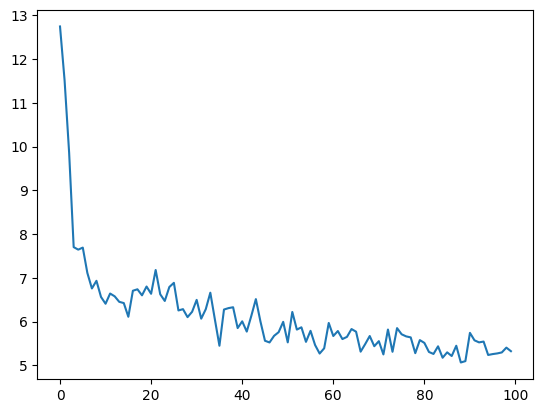

In [32]:
plt.plot(train_loss_list)

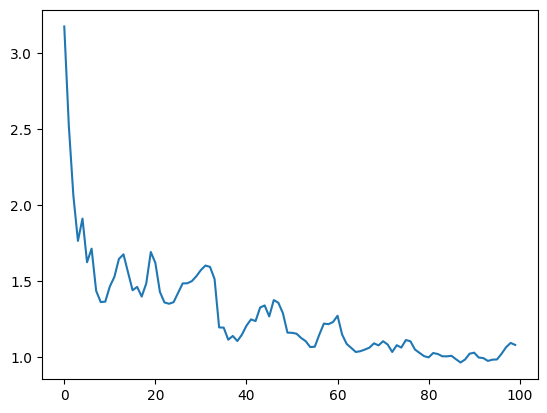

In [33]:
plt.plot(val_loss_list)

In [34]:
val_loss = 0
preds = torch.tensor([])
labels = torch.tensor([])
for i, batch in enumerate(val_loader):
    model.eval()
    mel, label = batch[0].to(device), torch.tensor(np.array(batch[1], dtype=np.float32))
    output = model(mel)
    output = output.squeeze(1)
    loss = loss_fn(output, label.cuda())
    val_loss += loss
    pred = output>0.5
    preds = torch.cat([preds,pred.cpu()])
    labels = torch.cat([labels,label.cpu()])

NameError: name 'loss_fn' is not defined

In [ ]:
tn, fp, fn, tp = confusion_matrix(preds, labels).ravel()

# test code

In [135]:
best_model = torch.load(os.path.join(save_path,'best_model.pt'))

In [162]:
val_loss, val_label_loss, val_time_loss, outputs, preds, labels = validation(best_model, optimizer, val_loader)
#make loss list for plot
iou_list, score_list, good_predicts, region_miss, no_inter, passed = iou_fn(labels, outputs)

#make confusion matrix
tn, fn, fp, tp = confusion_matrix(preds, labels[:,2]).ravel()
print(f'val_loss {val_loss:.4f}, precision : {tp/(tp+fp):.4f}, recall : {tp/(tp+fn):.4f}')
print(f'confusion_mat tp fn {tp, fn}')
print(f'              fp tn {fp, tn}')
print(f'good_predict : {good_predicts}, region_miss : {region_miss}, no_inter : {no_inter}, negative : {passed}')
torch.cuda.empty_cache()

val_loss 1.2610, precision : 0.9690, recall : 0.9690
confusion_mat tp fn (125, 4)
              fp tn (4, 125)
good_predict : 67, region_miss : 29, no_inter : 33, negative : 129


# predict from audio

predict : [False]


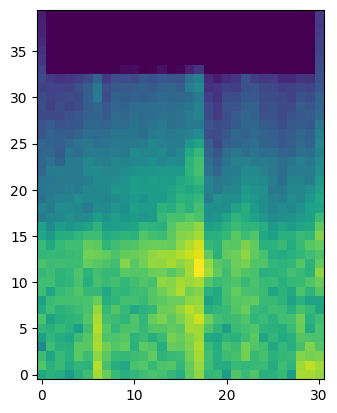

predict : [True], time : 0.26~0.42


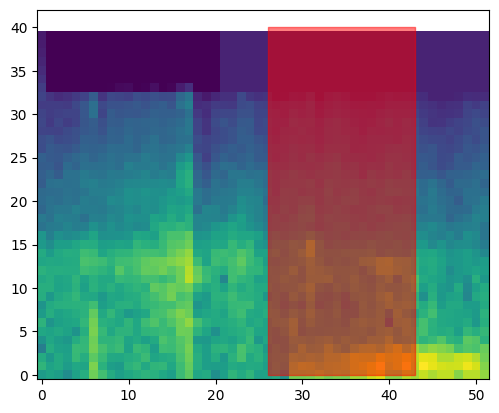

predict : [True], time : 0.4~0.7


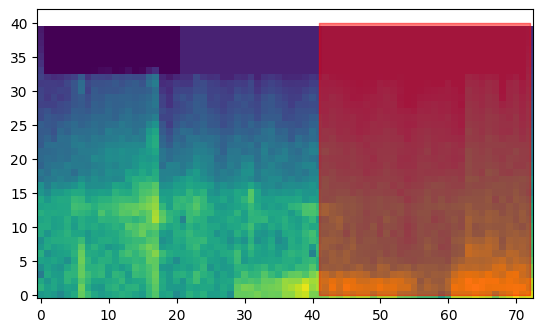

predict : [True], time : 0.6~0.9


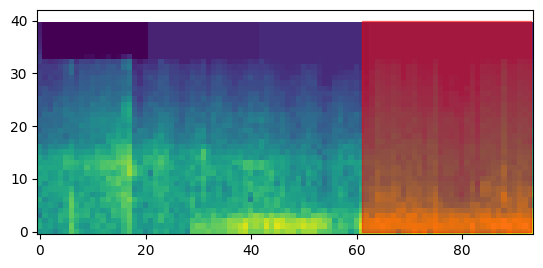

predict : [True], time : 0.8~1.1


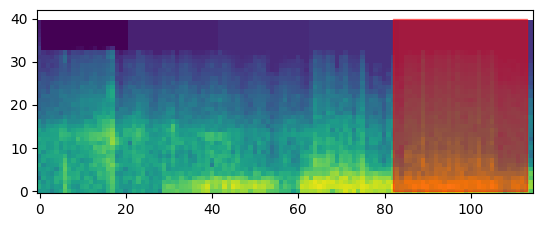

predict : [True], time : 1.05~1.2


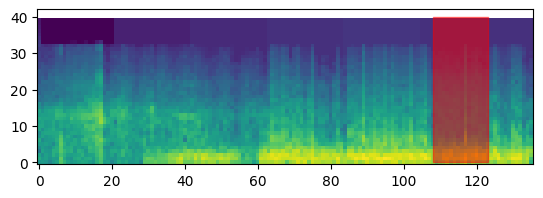

predict : [False]


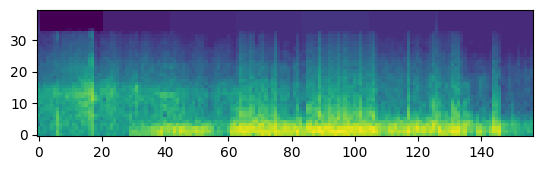

predict : [False]


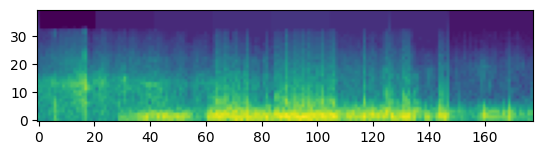

predict : [False]


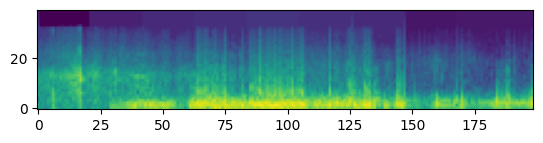

predict : [False]


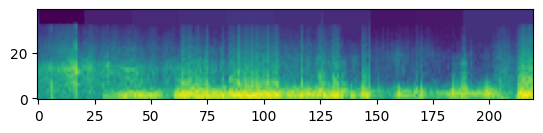

predict : [True], time : 2.0~2.3


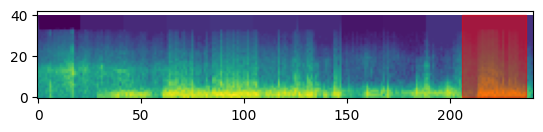

predict : [True], time : 2.2~2.5


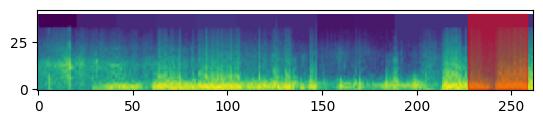

predict : [True], time : 2.4~2.7


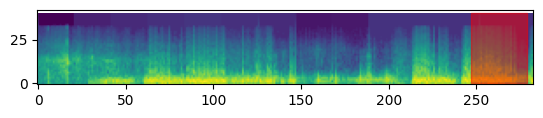

predict : [False]


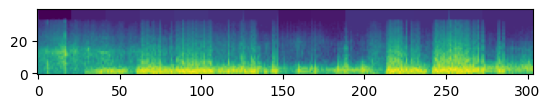

predict : [False]


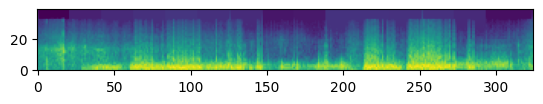

predict : [False]


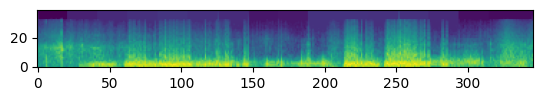

predict : [False]


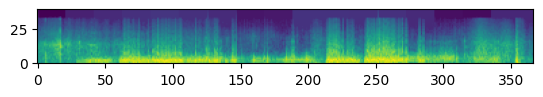

predict : [False]


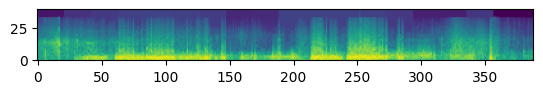

predict : [False]


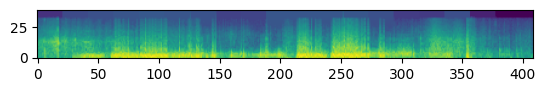

predict : [False]


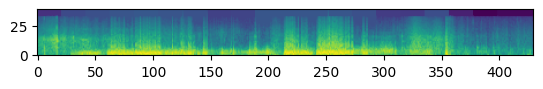

predict : [False]


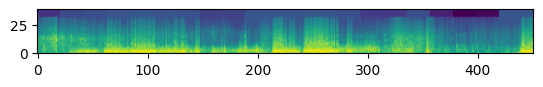

predict : [True], time : 4.26~4.41


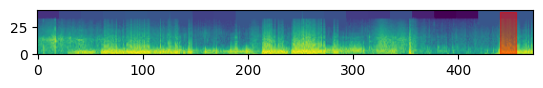

predict : [False]


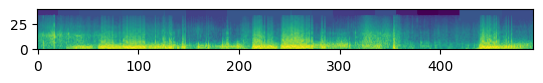

predict : [True], time : 4.6~4.9


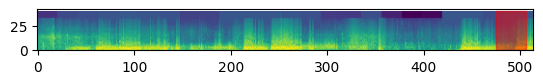

predict : [True], time : 4.8~5.1


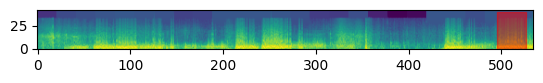

predict : [True], time : 5.0~5.3


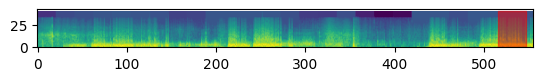

predict : [True], time : 5.2~5.5


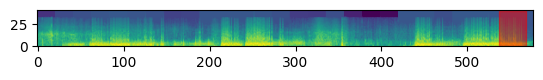

predict : [False]


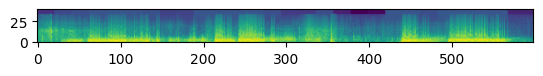

predict : [False]


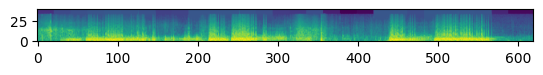

predict : [False]


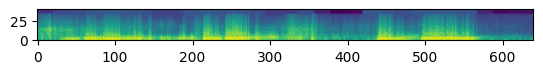

predict : [False]


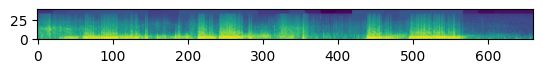

predict : [False]


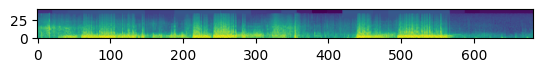

predict : [False]


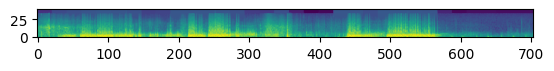

predict : [False]


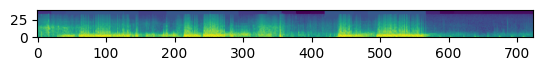

predict : [False]


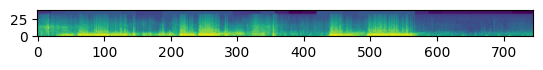

predict : [False]


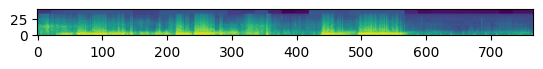

predict : [False]


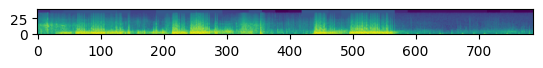

predict : [False]


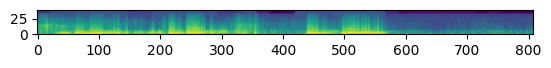

predict : [False]


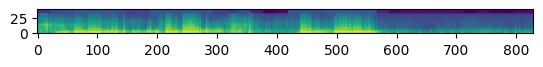

predict : [False]


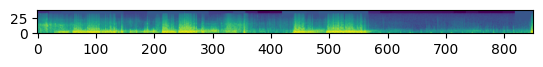

predict : [True], time : 8.0~8.3


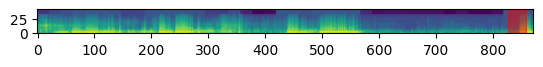

predict : [False]


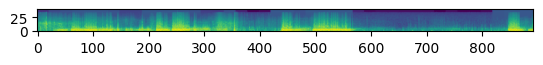

predict : [False]


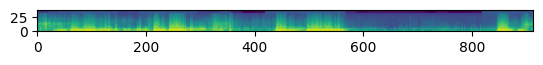

predict : [False]


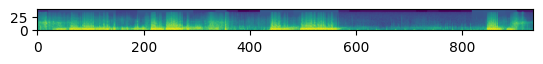

predict : [False]


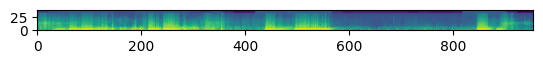

predict : [False]


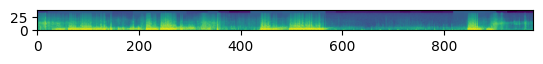

predict : [False]


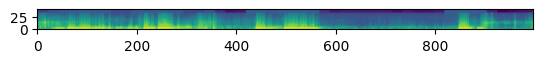

predict : [False]


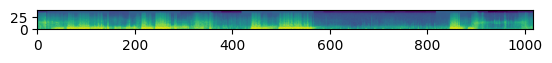

predict : [False]


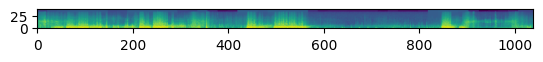

predict : [False]


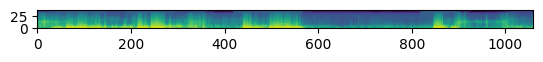

predict : [False]


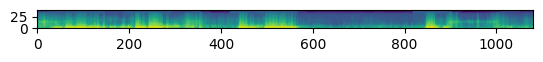

predict : [False]


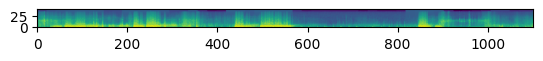

predict : [False]


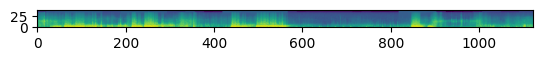

predict : [False]


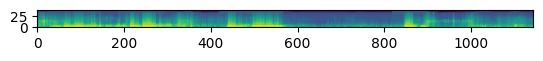

predict : [False]


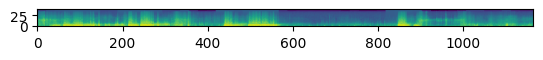

predict : [False]


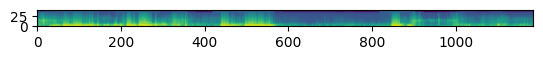

predict : [False]


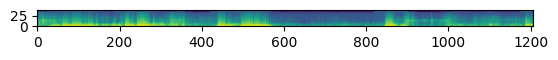

predict : [False]


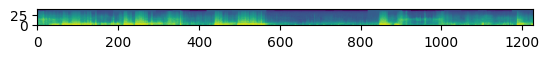

predict : [True], time : 11.6~11.9


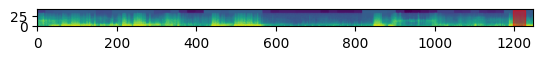

predict : [True], time : 11.8~12.1


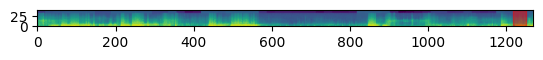

predict : [False]


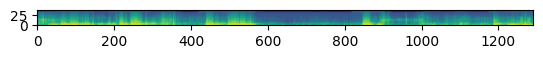

predict : [False]


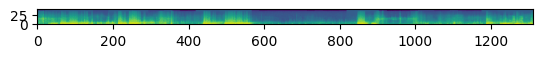

predict : [False]


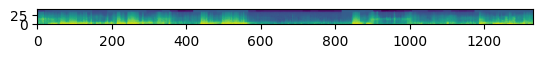

predict : [False]


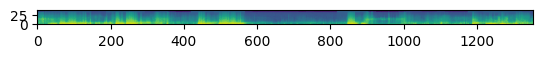

predict : [False]


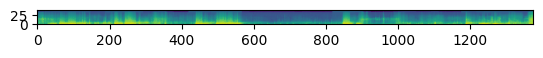

predict : [False]


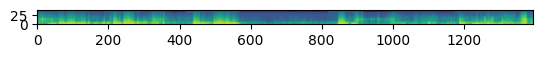

predict : [False]


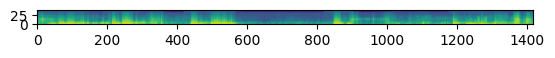

predict : [False]


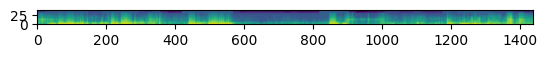

predict : [False]


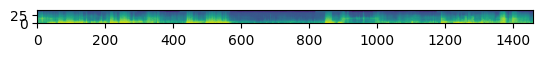

predict : [False]


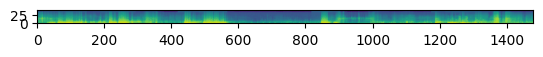

predict : [False]


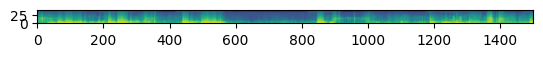

predict : [True], time : 14.2~14.5


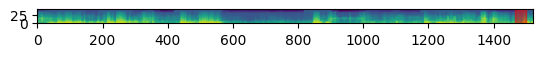

predict : [True], time : 14.4~14.7


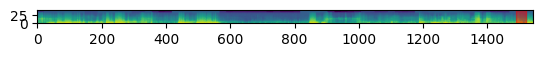

predict : [False]


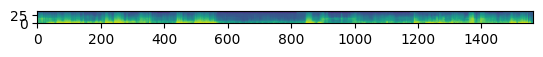

predict : [False]


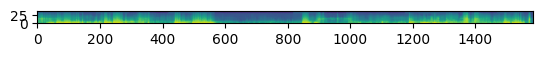

predict : [False]


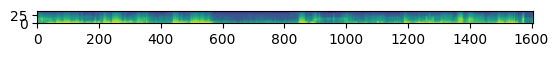

predict : [True], time : 15.25~15.4


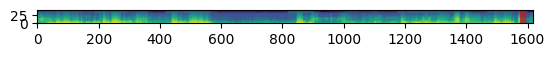

In [44]:
wav, sr = librosa.load('data/origin_wav/124y.wav')
wav = librosa.resample(wav, orig_sr=sr, target_sr=params['sr'])
interval_nums = int(np.ceil(len(wav)/params['sr']/params['wav_hop']))
mels = np.zeros([params['n_mels'], 31])
labels = []
predicts = []
whez_times = []
for i in range(interval_nums):
    #0.3초단위로 자르기(wav가 작으면 패딩시키기)
    wav_start = i*int(params['sr']*params['wav_hop'])
    wav_end = i*int(params['sr']*params['wav_hop']) + int(params['sr']*params['wav_len'])
    try : 
        new_wav = wav[wav_start:wav_end]
    except :
        new_wav = wav[wav_start:]
        zeros = np.zeros(int(params['sr']*params['wav_len'])-len(new_wav))
        new_wav = np.concatenate([new_wav, zeros])

    # make melspectrogram
    mel = librosa.feature.melspectrogram(y=np.array(new_wav), sr=params['sr'], hop_length=params['mel_hop'], win_length = params['mel_win'], n_fft=params['n_fft'], n_mels=params['n_mels'], dtype=np.float32)
    mel = librosa.core.power_to_db(mel)

    # predict from model
    output = model(torch.tensor(mel).cuda().unsqueeze(0))
    result = [True if output[0][2]>0.5 else False]
    pred_start = np.round(i*0.2 + 0.3*output[0][0].cpu().detach().numpy(), 2)
    pred_end = np.round(i*0.2 + 0.3*output[0][1].cpu().detach().numpy(), 2)

    # update list
    overlap_len = int(mel.shape[1]*(params['wav_len']-params['wav_hop'])/params['wav_len'])
    if i==0:
        mels = mel
    else:
        mels = mels[:, :mels.shape[1]-overlap_len]
        mels = np.concatenate([mels, mel], axis=1)
        plt.close()
    predicts.append([result, pred_start, pred_end])

    # print results
    fig = plt.figure()
    plt.imshow(mels, origin='lower')
    if result==[False]:
        print(f'predict : {result}')
    else:
        print(f'predict : {result}, time : {pred_start}~{pred_end}')
        whez_start = int(pred_start*31/0.3)
        whez_end = int(pred_end*31/0.3)
        whez_times.append([whez_start, whez_end])
        plt.fill_between([whez_start, whez_end], [params['n_mels'], params['n_mels']], alpha=0.5, color='r')
    plt.show()
    time.sleep(0.3)
    del new_wav

## make last plot

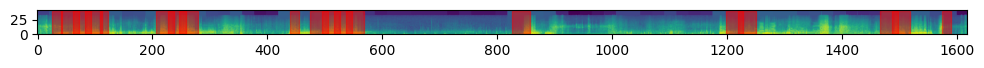

In [45]:
plt.figure(figsize=(12,10))
plt.imshow(mels, origin='lower')
for i, times in enumerate(whez_times):
    plt.fill_between([times[0], times[1]], [params['n_mels'], params['n_mels']], alpha=0.5, color='r')
plt.show()

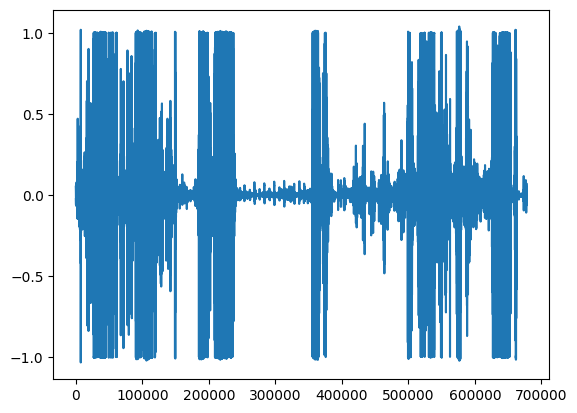

In [43]:
plt.plot(wav)